In [1]:
from os.path import join
import sys
from tqdm import tqdm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

DATA_DIR = '../data/01_processed'

In [2]:
tracking = pd.read_parquet(join(DATA_DIR, 'tracking.parquet'))
plays = pd.read_parquet(join(DATA_DIR, 'plays.parquet'))
games = pd.read_parquet(join(DATA_DIR, 'games.parquet'))
player_play = pd.read_parquet(join(DATA_DIR, 'player_play.parquet'))

# 1. Aggregate field control within RB vision cone
Apply this over the frames until the rb passes beyond the oline influence, to quantify how much space the rb has to run through. One possible limitation to this approach is rb skill will also likely lead to more open space, due to better vision, speed, or agility.

#### Calculate the euclidean distance from the ball carrier to each player for each frame 

In [3]:
rb_coords = (
    tracking[tracking['is_ball_carrier'] == 1]
    .set_index(['game_play_id', 'frame_id'])[['x', 'y']]
    .rename(columns={'x': 'ball_carrier_x', 'y': 'ball_carrier_y'})
)

tracking = tracking.merge(
    rb_coords,
    left_on=['game_play_id', 'frame_id'],
    right_index=True,
    how='left'
)

tracking['euclidean_dist_to_ball_carrier'] = (
    ((tracking['x'] - tracking['ball_carrier_x']) ** 2 +
     (tracking['y'] - tracking['ball_carrier_y']) ** 2) ** 0.5
).round(2)

tracking.drop(columns=['ball_carrier_x', 'ball_carrier_y'], inplace=True)

#### Find the closest offensive player to each defender. Mark the defender as engaged if they are within 3 feet of the offensive player

In [4]:
defenders = tracking[(tracking['offense'] == 0) & (tracking['club'] != 'football')].copy()
offense = tracking[(tracking['offense'] == 1) & (tracking['club'] != 'football')].copy()

defenders = defenders.rename(columns={'nfl_id': 'def_nfl_id', 'x': 'def_x', 'y': 'def_y'})
offense = offense.rename(columns={'nfl_id': 'off_nfl_id', 'x': 'off_x', 'y': 'off_y'})

merged = defenders.merge(
    offense[['game_play_id', 'frame_id', 'off_nfl_id', 'off_x', 'off_y']],
    on=['game_play_id', 'frame_id'],
    how='left'
)

merged['dist'] = np.sqrt((merged['def_x'] - merged['off_x'])**2 + (merged['def_y'] - merged['off_y'])**2)

merged = merged.sort_values(['game_play_id', 'frame_id', 'def_nfl_id', 'dist'])

# Get closest offensive player to each defender
closest = merged.loc[
    merged.groupby(['game_play_id', 'frame_id', 'def_nfl_id'])['dist'].idxmin(),
    ['game_play_id', 'frame_id', 'def_nfl_id', 'def_x', 'def_y', 
     'off_nfl_id', 'off_x', 'off_y', 'dist']
].copy()

# Rename columns
closest = closest.rename(columns={
    'off_x': 'x_closest_off_player',
    'off_y': 'y_closest_off_player',
    'off_nfl_id': 'closest_off_nfl_id',
    'dist': 'closest_off_dist'
})

# Mark engagement (3 feet == 1 yard)
closest['engaged'] = closest['closest_off_dist'] < 1

# Merge back to original tracking data
tracking = tracking.merge(
    closest[['game_play_id', 'frame_id', 'def_nfl_id', 'x_closest_off_player', 'y_closest_off_player', 'engaged']],
    left_on=['game_play_id', 'frame_id', 'nfl_id'],
    right_on=['game_play_id', 'frame_id', 'def_nfl_id'],
    how='left'
).drop(columns=['def_nfl_id'])

tracking['engaged'] = tracking['engaged'].fillna(False).astype(bool)

In [5]:
tracking.position_by_loc.value_counts(normalize=True)

CB     0.111145
WR     0.104182
TE     0.067632
OLB    0.066414
DT     0.065638
DE     0.064903
ILB    0.063432
FS     0.050935
RB     0.046968
SS     0.046252
QB     0.045468
RG     0.045455
C      0.045455
LG     0.045455
LT     0.045455
RT     0.045455
NT     0.019420
MLB    0.011034
FB     0.008451
LB     0.000641
DB     0.000212
Name: position_by_loc, dtype: float64

In [6]:
tracking.query('position_by_loc.isin(["OLB","DT","DE","ILB","NT","MLB","LB"])').engaged.value_counts(normalize=True)

True     0.575566
False    0.424434
Name: engaged, dtype: float64

#### Field Control functions

In [7]:
def influence(
        p: np.ndarray,
        p_i: np.ndarray,
        s: float,
        theta: float,
        rb_dist: float,
        is_offense: bool,
    ):
    '''
    Calculate the influence of a player on a point in the field.

    Args:
        p: coordinates of the point in the field.
        p_i: coordinates of the player.
        s: speed of the player.
        theta: direction of the player in radians.
        rb_dist: distance to the ball carrier.
        is_offense: boolean indicating if the player is on offense.
    Returns:    
        Influence value at the point.
    '''
    influence = (
        _bivariate_gaussian_pdf(p, p_i, s, theta, rb_dist) /
        _bivariate_gaussian_pdf(p_i, p_i, s, theta, rb_dist)
    )

    if is_offense:
        return influence
    return -influence

def _piecewise_function(x):
    """ Function reduces influence area radius if a player is closer to the rb """
    if x <= 18:
        return 0.01854*x**2 + 4  # Parabola for x <= 18
    else:
        return 10  # Flat line at y = 10 for x > 18

def _rotation_matrix(theta):
    return np.array([[np.cos(theta),-np.sin(theta)],
                     [np.sin(theta), np.cos(theta)]])

def _speed_ratio(s):
    return s**2 / 13**2
    
def _scaling_matrix(rb_dist, s):
    R = _piecewise_function(rb_dist)
    s_ratio = _speed_ratio(s)
    s_x = (R + (R * s_ratio)) / 2
    s_y = (R - (R * s_ratio)) / 2
    return np.array([[s_x,0],[0,s_y]])

def _mu(p_i, s_vect):
    s_unit_vector = s_vect / np.linalg.norm(s_vect)
    return p_i + (.5 * s_unit_vector)

def _cov(theta, rb_dist, s):
    S = _scaling_matrix(rb_dist, s)
    R = _rotation_matrix(theta)
    return R @ S @ S @ np.linalg.inv(R)

def _bivariate_gaussian_pdf(
    p: np.ndarray,
    p_i: np.ndarray,
    s: float,
    theta: float,
    rb_dist: float
):
    """
    Calculate the bivariate Gaussian PDF for a point in the field.
    
    Args:
        p: coordinates of the point in the field (2D vector).
        p_i: coordinates of the player (2D vector).
        s: player speed (float).
        theta: direction of motion in radians.
        rb_dist: Euclidean distance to the ball carrier.
        
    Returns:
        Float: PDF value at point p.
    """
    s_x = s * np.cos(theta)
    s_y = s * np.sin(theta)
    s_vect = np.array([s_x, s_y])
    
    mu = _mu(p_i, s_vect)
    sigma = _cov(theta, rb_dist, s)
    
    diff = p - mu
    constant = 1 / (2 * np.pi * np.sqrt(np.linalg.det(sigma)))
    exponent = -0.5 * diff.T @ np.linalg.inv(sigma) @ diff
    return constant * np.exp(exponent)

#### Visualize the field control within the ball carriers vision cone. This is filtered down to the frames of a play where the oline blocking has the greatest effect

In [76]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Arc, Wedge
from IPython.display import HTML
import numpy as np
from shapely import MultiPoint
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable

game_play_id = '2022091104_1660' #'2022091105_1742'

df_all = tracking.query('game_play_id == @game_play_id and club != "football"').copy()
frame_ids = sorted(df_all['frame_id'].unique())
yardline = plays.query('game_play_id == @game_play_id').absolute_yardline_number.values[0]

field_control_granularity = 2
xmin, xmax = 0, 53.3

# Create a wider figure to accommodate the legend and colorbar
fig, ax = plt.subplots(figsize=(14, 8))

def create_mesh(df):
    ybuffer = 1
    ymin, ymax = df['y'].min() - ybuffer, df['y'].max() + ybuffer
    X, Y = np.meshgrid(np.arange(xmin, xmax + field_control_granularity, field_control_granularity),
                       np.arange(ymin, ymax + field_control_granularity, field_control_granularity))
    coords = np.column_stack([X.ravel(), Y.ravel()]).reshape((X.shape[0], X.shape[1], 2))
    return X, Y, coords

def compute_field_control(frame_df, coords):
    smoothing_param = sys.float_info.epsilon
    grid_shape = coords.shape[:2]
    field_control = np.zeros(grid_shape)

    cols = ['x', 'y', 's', 'dir', 'offense', 'euclidean_dist_to_ball_carrier',
            'x_closest_off_player', 'y_closest_off_player', 'engaged']
    for i, row_coords in enumerate(coords):
        for j, coord in enumerate(row_coords):
            for row in frame_df[cols].itertuples(index=False):
                field_control[i, j] += influence(
                    p=coord,
                    p_i=np.array([row.x, row.y]),
                    s=row.s + smoothing_param,
                    theta=row.dir * np.pi / 180,
                    rb_dist=row.euclidean_dist_to_ball_carrier,
                    is_offense=row.offense
                )

    return 1 / (1 + np.exp(-field_control))

def _get_rb_vision_area(rb_pos, rb_dir_rad, cone_length=3, cone_angle_deg=90, semicircle_radius=1):
    """Generate points for combined vision area with circular arc front."""
    cone_half_angle = np.radians(cone_angle_deg / 2)
    
    # Create the vision cone with circular arc front
    cone_points = []
    num_arc_points = 30
    
    # Create the circular arc at the front of the cone
    for i in range(num_arc_points + 1):
        angle = -cone_half_angle + (2 * cone_half_angle * i / num_arc_points)
        x = cone_length * np.cos(angle)
        y = cone_length * np.sin(angle)
        cone_points.append([x, y])
    
    # Create the semicircle (1 yard radius) excluding the cone area
    semicircle_points = []
    num_semicircle_points = 30
    start_angle = cone_half_angle
    end_angle = 2 * np.pi - cone_half_angle
    
    for i in range(num_semicircle_points + 1):
        angle = start_angle + (end_angle - start_angle) * i / num_semicircle_points
        x = semicircle_radius * np.cos(angle)
        y = semicircle_radius * np.sin(angle)
        semicircle_points.append([x, y])
    
    # Combine all points in order to form a single polygon
    combined_points = []
    
    # Start at the RB position (origin)
    combined_points.append([0, 0])
    
    # Add points along the left side of the cone (from RB to arc)
    num_side_points = 10
    for i in range(1, num_side_points):
        progress = i / num_side_points
        dist = cone_length * progress
        angle = -cone_half_angle
        x = dist * np.cos(angle)
        y = dist * np.sin(angle)
        combined_points.append([x, y])
    
    # Add the circular arc points (from left to right)
    combined_points.extend(cone_points)
    
    # Add points along the right side of the cone (from arc back to RB)
    for i in range(num_side_points - 1, 0, -1):
        progress = i / num_side_points
        dist = cone_length * progress
        angle = cone_half_angle
        x = dist * np.cos(angle)
        y = dist * np.sin(angle)
        combined_points.append([x, y])
    
    # Add semicircle points (clockwise from right to left)
    combined_points.extend(semicircle_points)
    
    # Rotate and translate to RB position and direction
    rot_matrix = np.array([
        [np.cos(rb_dir_rad), -np.sin(rb_dir_rad)],
        [np.sin(rb_dir_rad), np.cos(rb_dir_rad)]
    ])
    
    combined_points = np.array(combined_points)
    return (rot_matrix @ combined_points.T).T + rb_pos

def calculate_fc(fc, coords, polygons):
    combined_mask = np.zeros(coords.shape[:2], dtype=bool)
    for vertices in polygons:
        path = Path(vertices)
        mask = path.contains_points(coords.reshape(-1, 2)).reshape(coords.shape[:2])
        combined_mask |= mask
    return fc[combined_mask].mean() if np.any(combined_mask) else 0

# Calculate global limits once
ymin_global = df_all['y'].min() - 5
ymax_global = df_all['y'].max() + 5

X_global, Y_global, coords_global = create_mesh(df_all)

def update(frame_id):
    ax.clear()
    frame_df = df_all[df_all['frame_id'] == frame_id]

    fc = compute_field_control(frame_df, coords_global)

    # Plot FC map with colorbar
    im = ax.imshow(fc, extent=[xmin, xmax, ymin_global, ymax_global],
              origin='lower', cmap="bwr", alpha=0.5, aspect='auto', zorder=0, vmin=0, vmax=1)

    # Convex hull of O-line
    points = [tuple(v) for v in frame_df.query('is_part_of_oline')[['x', 'y']].values.tolist()]
    if len(points) >= 3:
        convex_hull = MultiPoint(points).convex_hull
        x, y = convex_hull.exterior.xy
        ax.plot(x, y, color='maroon', linewidth=2, label='Convex Hull of O-Line')

    # RB combined vision area (cone + semicircle)
    rb_data = frame_df[frame_df['is_ball_carrier'] == 1]
    if not rb_data.empty:
        rb = rb_data.iloc[0]
        rb_pos = np.array([rb.x, rb.y])
        rb_dir_rad = rb.dir * np.pi / 180
        rb_speed = rb.s

        # Create combined vision area with circular arc front
        vision_vertices = _get_rb_vision_area(rb_pos, rb_dir_rad, cone_length=3, cone_angle_deg=90, semicircle_radius=1)
        ax.add_patch(plt.Polygon(vision_vertices, color='black', alpha=0.3, linewidth=2, fill=True, zorder=3))

        # Calculate field control in the combined vision area
        vision_fc = calculate_fc(fc, coords_global, [vision_vertices])
        
        ax.text(0.02, 0.95, f"FC in Vision Area: {vision_fc:.2f}",
                transform=ax.transAxes, fontsize=10,
                bbox=dict(facecolor='white', alpha=0.7))

    # Plot legend items
    ax.plot([], [], color='purple', alpha=0.3, linewidth=2, label='RB Vision Area', zorder=3)

    oline = frame_df[frame_df['is_part_of_oline']]
    rb = frame_df[frame_df['is_ball_carrier'] == 1]
    defense = frame_df[(frame_df['offense'] == 0)]
    offense = frame_df[(frame_df['offense'] == 1) & (~frame_df['is_part_of_oline'])]

    ax.scatter(oline['x'], oline['y'], label='O-Line', s=50, color='maroon', zorder=2)
    ax.scatter(rb['x'], rb['y'], label='Ball Carrier', s=50, color='black', zorder=4)
    ax.scatter(defense['x'], defense['y'], label='Defense', s=50, color='blue', zorder=2)
    ax.scatter(offense['x'], offense['y'], label='Offense', s=50, color='red', zorder=2)

    ax.hlines(yardline, 0, 53.3, color='#436ee6', linestyle='-', lw=2, zorder=1)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin_global, ymax_global)
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_xticks([])
    ax.set_xticklabels([])

    # Plot the rb path across all frames
    rb_path = df_all[df_all['is_ball_carrier'] == 1][['x', 'y']].values
    ax.plot(rb_path[:, 0], rb_path[:, 1], color='black', linestyle='--', linewidth=1, alpha=0.7, zorder=1)
    
    # Adjust legend position to be inside the plot in the upper right
    ax.legend(loc='upper right', bbox_to_anchor=(.98, .98), borderaxespad=0.)

# Tight layout to prevent overlap
fig.tight_layout()

ani = FuncAnimation(fig, update, frames=frame_ids, interval=200, repeat=False)
plt.close()
HTML(ani.to_jshtml())

In [11]:
import numpy as np
from matplotlib.path import Path
# ['SS', 'QB', 'RG', 'CB', 'OLB', 'WR', 'DE', 'ILB', 'FS', 'C', 'NT',
#        'RB', 'TE', 'LG', 'LT', 'RT', None, 'DT', 'MLB', 'FB', 'LB', 'DB']
def_positions = ['SS', 'CB', 'OLB', 'DE', 'ILB', 'FS', 'NT',
      'DT', 'MLB', 'LB', 'DB']
off_positions = ['QB', 'WR', 'TE', 'RB', 'FB', 'C', 'LG', 'RG', 'LT', 'RT']
tracking['defense'] = tracking['position_by_loc'].isin(def_positions)

def calculate_play_rb_field_control(game_play_id, cone_granularity=0.1):
    """Calculate average field control in RB's merged vision+semicircle polygon, 
    with engaged scaling factor applied."""
    smoothing_param = sys.float_info.epsilon
    
    df_all = tracking.query('game_play_id == @game_play_id and club != "football"').copy()
    frame_ids = sorted(df_all['frame_id'].unique())
    cone_stats = {'frame_values': [], 'average': 0}
    
    for frame_id in frame_ids:
        frame_df = df_all[df_all['frame_id'] == frame_id]
        rb_data = frame_df[frame_df['is_ball_carrier'] == 1]
        
        if not rb_data.empty:
            rb = rb_data.iloc[0]
            
            # Build merged cone+circle shape
            cone_vertices = get_rb_vision_plus_circle(
                rb_x=rb.x,
                rb_y=rb.y,
                rb_dir=rb.dir,
                vision_cone_angle=90
            )
            path = Path(cone_vertices)
            
            # Grid around the polygon
            cone_buffer = 2  # yards buffer
            x_min, x_max = cone_vertices[:, 0].min() - cone_buffer, cone_vertices[:, 0].max() + cone_buffer
            y_min, y_max = cone_vertices[:, 1].min() - cone_buffer, cone_vertices[:, 1].max() + cone_buffer
            
            X = np.arange(x_min, x_max + cone_granularity, cone_granularity)
            Y = np.arange(y_min, y_max + cone_granularity, cone_granularity)
            X, Y = np.meshgrid(X, Y)
            coords = np.column_stack([X.ravel(), Y.ravel()])
            
            # Keep only points inside the polygon
            mask = path.contains_points(coords)
            cone_coords = coords[mask]
            
            if len(cone_coords) > 0:
                fc_values = np.zeros(len(cone_coords))
                
                cols = [
                    'x', 'y', 's', 'dir', 'offense',
                    'euclidean_dist_to_ball_carrier',
                    'x_closest_off_player', 'y_closest_off_player', 'engaged',
                    # 'defense'
                ]
                
                for i, coord in enumerate(cone_coords):
                    for row in frame_df[cols].itertuples(index=False):
                        # Only consider defenders
                        # if not row.defense:
                        #     continue

                        # scale = 1
                        
                        # Engaged scaling factor
                        # if row.engaged:
                        #     defender_pos = np.array([row.x, row.y])
                        #     off_player_pos = np.array([row.x_closest_off_player, row.y_closest_off_player])
                        #     point_pos = np.array(coord)
                            
                        #     vec_def_to_off = off_player_pos - defender_pos
                        #     vec_point_to_off = off_player_pos - point_pos
                            
                        #     # Avoid division by zero
                        #     dot_prod = np.dot(vec_def_to_off, vec_point_to_off)
                        #     norm_prod = (np.linalg.norm(vec_def_to_off) * np.linalg.norm(vec_point_to_off) + 1e-8)
                        #     angle = np.degrees(np.arccos(dot_prod / norm_prod))
                            
                        #     # Scale factor (0 at 180°, 1 at 0°), smoothed by sqrt
                        #     scale = ((180 - angle) / 180) ** 0.5
                        #     scale = np.clip(scale, 0, 1)
                        
                        # fc_values[i] += scale * influence(
                        fc_values[i] += influence(
                            p=coord,
                            p_i=np.array([row.x, row.y]),
                            s=row.s + smoothing_param,
                            theta=row.dir * np.pi / 180,
                            rb_dist=row.euclidean_dist_to_ball_carrier,
                            is_offense=row.offense
                        )
                
                # Apply sigmoid to FC values
                fc_values = 1 / (1 + np.exp(-fc_values))
                cone_stats['frame_values'].append(fc_values.mean())
    
    if cone_stats['frame_values']:
        cone_stats['average'] = np.mean(cone_stats['frame_values'])
    
    return cone_stats['average']

def get_rb_vision_plus_circle(rb_x, rb_y, rb_dir, vision_cone_angle=90):
    """
    Returns a single polygon that merges the RB's vision cone with the surrounding semicircle
    so there's no overlap or double counting.
    """

    rb_coords = np.vstack([
        _get_vision_cone(
            rb_pos = np.array([rb_x, rb_y]),
            rb_dir_rad = np.radians(rb_dir),
            cone_angle_deg=vision_cone_angle,
            cone_length=3,
            spacing=0.25
        ),
        _get_rb_semicircle(
            rb_pos = np.array([rb_x, rb_y]),
            rb_dir_rad = np.radians(rb_dir),
            radius=1,
            cone_angle_deg=90,
            spacing=0.25
        )
    ])

    return rb_coords

def _get_vision_cone(
    rb_pos,
    rb_dir_rad,
    cone_angle_deg=45,
    cone_length=3,
    spacing=0.5
):
    """Generate evenly spaced points inside RB vision cone."""
    cone_half_angle = np.radians(cone_angle_deg / 2)

    # Create a grid that covers the cone bounding box
    max_radius = cone_length
    grid_x, grid_y = np.meshgrid(
        np.arange(-max_radius, max_radius + spacing, spacing),
        np.arange(-max_radius, max_radius + spacing, spacing)
    )
    points = np.column_stack([grid_x.ravel(), grid_y.ravel()])

    # Keep only points in front of RB within cone length and angle
    dist = np.linalg.norm(points, axis=1)
    angles = np.arctan2(points[:, 1], points[:, 0])  # relative to facing +x
    mask = (
        (dist <= cone_length) &
        (np.abs(angles) <= cone_half_angle)
    )
    cone_points = points[mask]

    # Rotate and translate to RB position
    rot_matrix = np.array([
        [np.cos(rb_dir_rad), -np.sin(rb_dir_rad)],
        [np.sin(rb_dir_rad), np.cos(rb_dir_rad)]
    ])
    return (rot_matrix @ cone_points.T).T + rb_pos

def _get_rb_semicircle(
    rb_pos,
    rb_dir_rad,
    radius=1,
    cone_angle_deg=45,
    spacing=0.5
):
    """Generate evenly spaced points in semicircle behind RB."""
    excluded_half_angle = np.radians((cone_angle_deg) / 2)

    # Create a grid that covers full circle bounding box
    grid_x, grid_y = np.meshgrid(
        np.arange(-radius, radius + spacing, spacing),
        np.arange(-radius, radius + spacing, spacing)
    )
    points = np.column_stack([grid_x.ravel(), grid_y.ravel()])

    dist = np.linalg.norm(points, axis=1)
    angles = np.arctan2(points[:, 1], points[:, 0])  # relative to +x direction

    # Keep points within circle but outside cone wedge
    mask = (
        (dist <= radius) &
        ((angles > excluded_half_angle) | (angles < -excluded_half_angle))
    )
    semi_points = points[mask]

    # Rotate and translate to RB position
    rot_matrix = np.array([
        [np.cos(rb_dir_rad), -np.sin(rb_dir_rad)],
        [np.sin(rb_dir_rad), np.cos(rb_dir_rad)]
    ])
    return (rot_matrix @ semi_points.T).T + rb_pos


# Process all plays
# play_results = {}
# week_1_game_ids = games.query('week == 1')['game_id'].unique().tolist()
# week_1_game_play_ids = plays.query('game_id in @week_1_game_ids')['game_play_id'].unique().tolist()
# for game_play_id in tqdm(week_1_game_play_ids, desc='Calculating Field Control in Cones for week 1', total=len(week_1_game_play_ids)):
#     avg_fc = calculate_play_rb_field_control(game_play_id, cone_granularity=0.5)
#     play_results[game_play_id] = avg_fc

In [12]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML
import numpy as np
from shapely import MultiPoint
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable

game_play_id = '2022091105_3712' #'2022091105_1742'

df_all = tracking.query('game_play_id == @game_play_id and club != "football"').copy()
frame_ids = sorted(df_all['frame_id'].unique())
los = plays.query('game_play_id == @game_play_id').absolute_yardline_number.values[0]

field_control_granularity = .2
xmin, xmax = 0, 53.3

# Create a wider figure to accommodate the legend and colorbar
fig, ax = plt.subplots(figsize=(14, 8))

def create_mesh(df):
    ybuffer = 1
    ymin, ymax = df['y'].min() - ybuffer, df['y'].max() + ybuffer
    X, Y = np.meshgrid(np.arange(xmin, xmax + field_control_granularity, field_control_granularity),
                       np.arange(ymin, ymax + field_control_granularity, field_control_granularity))
    coords = np.column_stack([X.ravel(), Y.ravel()]).reshape((X.shape[0], X.shape[1], 2))
    return X, Y, coords

def compute_field_control(frame_df, coords):
    smoothing_param = sys.float_info.epsilon
    grid_shape = coords.shape[:2]
    field_control = np.zeros(grid_shape)

    cols = ['x', 'y', 's', 'dir', 'offense', 'euclidean_dist_to_ball_carrier',
            'x_closest_off_player', 'y_closest_off_player', 'engaged']
    for i, row_coords in enumerate(coords):
        for j, coord in enumerate(row_coords):
            for row in frame_df[cols].itertuples(index=False):
                field_control[i, j] += influence(
                    p=coord,
                    p_i=np.array([row.x, row.y]),
                    s=row.s + smoothing_param,
                    theta=row.dir * np.pi / 180,
                    rb_dist=row.euclidean_dist_to_ball_carrier,
                    is_offense=row.offense
                )

    return 1 / (1 + np.exp(-field_control))

def calculate_fc(fc, coords, polygons):
    combined_mask = np.zeros(coords.shape[:2], dtype=bool)
    for vertices in polygons:
        path = Path(vertices)
        mask = path.contains_points(coords.reshape(-1, 2)).reshape(coords.shape[:2])
        combined_mask |= mask
    return fc[combined_mask].mean() if np.any(combined_mask) else 0

# Calculate global limits once
ymin_global = df_all['y'].min() - 5
ymax_global = df_all['y'].max() + 5

X_global, Y_global, coords_global = create_mesh(df_all)

def update(frame_id):
    ax.clear()
    frame_df = df_all[df_all['frame_id'] == frame_id]

    fc = compute_field_control(frame_df, coords_global)

    # Plot ENDZONE with angled lines and black border (110 to 120 yards)
    endzone_ymin, endzone_ymax = 110, 120
    
    # Add black border line at the start of endzone
    ax.axhline(y=endzone_ymin, color='grey', linewidth=3, zorder=0)
    
    # Add black "ENDZONE" text
    ax.text((xmin + xmax) / 2, (endzone_ymin + endzone_ymax) / 2,
            'ENDZONE', fontsize=40, color='grey', fontweight='bold', 
            ha='center', va='center', alpha=0.8, zorder=0,
            bbox=dict(boxstyle="round,pad=1", facecolor='none', edgecolor='none'))
    
    # Plot the field yardlines every 5 yards from 15 to 115, but only if they are in the limits
    yardlines = np.arange(15, 110, 5)
    for yardline in yardlines:
        if yardline >= ymin_global and yardline <= ymax_global:
            linetype = 'dotted' if yardline % 10 != 0 else 'solid'
            ax.hlines(yardline, xmin, xmax, color='grey', linestyle=linetype, lw=3, zorder=0)

    # Plot FC map with colorbar
    im = ax.imshow(fc, extent=[xmin, xmax, ymin_global, ymax_global],
              origin='lower', cmap="bwr", alpha=0.5, aspect='auto', zorder=2, vmin=0, vmax=1)

    # Rest of the code remains the same...
    # Convex hull of O-line
    points = [tuple(v) for v in frame_df.query('is_part_of_oline')[['x', 'y']].values.tolist()]
    if len(points) >= 3:
        convex_hull = MultiPoint(points).convex_hull
        x, y = convex_hull.exterior.xy
        ax.plot(x, y, color='maroon', linewidth=2, label='Convex Hull of O-Line', zorder=3)

    # RB combined vision area (cone + semicircle)
    rb_data = frame_df[frame_df['is_ball_carrier'] == 1]

    # Plot legend items
    ax.plot([], [], color='purple', alpha=0.3, linewidth=2, label='RB Vision Area', zorder=3)

    oline = frame_df[frame_df['is_part_of_oline']]
    rb = frame_df[frame_df['is_ball_carrier'] == 1]
    defense = frame_df[(frame_df['offense'] == 0)]
    offense = frame_df[(frame_df['offense'] == 1) & (~frame_df['is_part_of_oline'])]

    ax.scatter(oline['x'], oline['y'], label='O-Line', s=50, color='maroon', zorder=3)
    ax.scatter(rb['x'], rb['y'], label='Ball Carrier', s=50, color='black', zorder=5)
    ax.scatter(defense['x'], defense['y'], label='Defense', s=50, color='blue', zorder=3)
    ax.scatter(offense['x'], offense['y'], label='Offense', s=50, color='red', zorder=3)

    ax.hlines(los, 0, 53.3, color='blue', linestyle='-', lw=3, zorder=1)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin_global, ymax_global)
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Plot the rb path across all frames
    rb_path = df_all[df_all['is_ball_carrier'] == 1][['x', 'y']].values
    ax.plot(rb_path[:, 0], rb_path[:, 1], color='black', linestyle='--', linewidth=1, alpha=0.7, zorder=1)
    
    # Adjust legend position to be inside the plot in the upper right
    ax.legend(loc='upper right', bbox_to_anchor=(.98, .98), borderaxespad=0.)

# Tight layout to prevent overlap
fig.tight_layout()

ani = FuncAnimation(fig, update, frames=frame_ids, interval=200, repeat=False)

# Save as video file (MP4)
writer = FFMpegWriter(fps=5, metadata=dict(artist='Me'), bitrate=1800)
ani.save('../results/field_control_animation.mp4', writer=writer)

plt.close()
HTML(ani.to_jshtml())

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML
import numpy as np
from shapely import MultiPoint
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable

game_play_id = '2022091104_1660' #'2022091105_1742'

df_all = tracking.query('game_play_id == @game_play_id and club != "football"').copy()
frame_ids = sorted(df_all['frame_id'].unique())
los = plays.query('game_play_id == @game_play_id').absolute_yardline_number.values[0]

field_control_granularity = .2
xmin, xmax = 0, 53.3

# Create a wider figure to accommodate the legend and colorbar
fig, ax = plt.subplots(figsize=(14, 8))

def create_mesh(df):
    ybuffer = 1
    ymin, ymax = df['y'].min() - ybuffer, df['y'].max() + ybuffer
    X, Y = np.meshgrid(np.arange(xmin, xmax + field_control_granularity, field_control_granularity),
                       np.arange(ymin, ymax + field_control_granularity, field_control_granularity))
    coords = np.column_stack([X.ravel(), Y.ravel()]).reshape((X.shape[0], X.shape[1], 2))
    return X, Y, coords

def compute_field_control(frame_df, coords):
    smoothing_param = sys.float_info.epsilon
    grid_shape = coords.shape[:2]
    field_control = np.zeros(grid_shape)

    cols = ['x', 'y', 's', 'dir', 'offense', 'euclidean_dist_to_ball_carrier',
            'x_closest_off_player', 'y_closest_off_player', 'engaged']
    for i, row_coords in enumerate(coords):
        for j, coord in enumerate(row_coords):
            for row in frame_df[cols].itertuples(index=False):
                field_control[i, j] += influence(
                    p=coord,
                    p_i=np.array([row.x, row.y]),
                    s=row.s + smoothing_param,
                    theta=row.dir * np.pi / 180,
                    rb_dist=row.euclidean_dist_to_ball_carrier,
                    is_offense=row.offense
                )

    return 1 / (1 + np.exp(-field_control))

def _get_rb_vision_area(rb_pos, rb_dir_rad, cone_length=3, cone_angle_deg=90, semicircle_radius=1):
    """Generate points for combined vision area with circular arc front."""
    cone_half_angle = np.radians(cone_angle_deg / 2)
    
    # Create the vision cone with circular arc front
    cone_points = []
    num_arc_points = 30
    
    # Create the circular arc at the front of the cone
    for i in range(num_arc_points + 1):
        angle = -cone_half_angle + (2 * cone_half_angle * i / num_arc_points)
        x = cone_length * np.cos(angle)
        y = cone_length * np.sin(angle)
        cone_points.append([x, y])
    
    # Create the semicircle (1 yard radius) excluding the cone area
    semicircle_points = []
    num_semicircle_points = 30
    start_angle = cone_half_angle
    end_angle = 2 * np.pi - cone_half_angle
    
    for i in range(num_semicircle_points + 1):
        angle = start_angle + (end_angle - start_angle) * i / num_semicircle_points
        x = semicircle_radius * np.cos(angle)
        y = semicircle_radius * np.sin(angle)
        semicircle_points.append([x, y])
    
    # Combine all points in order to form a single polygon
    combined_points = []
    
    # Start at the RB position (origin)
    combined_points.append([0, 0])
    
    # Add points along the left side of the cone (from RB to arc)
    num_side_points = 10
    for i in range(1, num_side_points):
        progress = i / num_side_points
        dist = cone_length * progress
        angle = -cone_half_angle
        x = dist * np.cos(angle)
        y = dist * np.sin(angle)
        combined_points.append([x, y])
    
    # Add the circular arc points (from left to right)
    combined_points.extend(cone_points)
    
    # Add points along the right side of the cone (from arc back to RB)
    for i in range(num_side_points - 1, 0, -1):
        progress = i / num_side_points
        dist = cone_length * progress
        angle = cone_half_angle
        x = dist * np.cos(angle)
        y = dist * np.sin(angle)
        combined_points.append([x, y])
    
    # Add semicircle points (clockwise from right to left)
    combined_points.extend(semicircle_points)
    
    # Rotate and translate to RB position and direction
    rot_matrix = np.array([
        [np.cos(rb_dir_rad), -np.sin(rb_dir_rad)],
        [np.sin(rb_dir_rad), np.cos(rb_dir_rad)]
    ])
    
    combined_points = np.array(combined_points)
    return (rot_matrix @ combined_points.T).T + rb_pos

def calculate_fc(fc, coords, polygons):
    combined_mask = np.zeros(coords.shape[:2], dtype=bool)
    for vertices in polygons:
        path = Path(vertices)
        mask = path.contains_points(coords.reshape(-1, 2)).reshape(coords.shape[:2])
        combined_mask |= mask
    return fc[combined_mask].mean() if np.any(combined_mask) else 0

# Calculate global limits once
ymin_global = df_all['y'].min() - 5
ymax_global = df_all['y'].max() + 5

X_global, Y_global, coords_global = create_mesh(df_all)

def update(frame_id):
    ax.clear()
    frame_df = df_all[df_all['frame_id'] == frame_id]

    fc = compute_field_control(frame_df, coords_global)

    # Plot ENDZONE with angled lines and black border (110 to 120 yards)
    endzone_ymin, endzone_ymax = 110, 120
    
    # Add black border line at the start of endzone
    ax.axhline(y=endzone_ymin, color='grey', linewidth=3, zorder=0)
    
    # Add black "ENDZONE" text
    ax.text((xmin + xmax) / 2, (endzone_ymin + endzone_ymax) / 2,
            'ENDZONE', fontsize=40, color='grey', fontweight='bold', 
            ha='center', va='center', alpha=0.8, zorder=0,
            bbox=dict(boxstyle="round,pad=1", facecolor='none', edgecolor='none'))
    
    # Plot the field yardlines every 5 yards from 15 to 115, but only if they are in the limits
    yardlines = np.arange(15, 110, 5)
    for yardline in yardlines:
        if yardline >= ymin_global and yardline <= ymax_global:
            linetype = 'dotted' if yardline % 10 != 0 else 'solid'
            ax.hlines(yardline, xmin, xmax, color='grey', linestyle=linetype, lw=3, zorder=0)

    # Plot FC map with colorbar
    im = ax.imshow(fc, extent=[xmin, xmax, ymin_global, ymax_global],
              origin='lower', cmap="bwr", alpha=0.5, aspect='auto', zorder=2, vmin=0, vmax=1)

    # Rest of the code remains the same...
    # Convex hull of O-line
    points = [tuple(v) for v in frame_df.query('is_part_of_oline')[['x', 'y']].values.tolist()]
    if len(points) >= 3:
        convex_hull = MultiPoint(points).convex_hull
        x, y = convex_hull.exterior.xy
        ax.plot(x, y, color='maroon', linewidth=2, label='Convex Hull of O-Line', zorder=3)

    # RB combined vision area (cone + semicircle)
    rb_data = frame_df[frame_df['is_ball_carrier'] == 1]
    if not rb_data.empty:
        rb = rb_data.iloc[0]
        rb_pos = np.array([rb.x, rb.y])
        rb_dir_rad = rb.dir * np.pi / 180
        rb_speed = rb.s

        # Create combined vision area with circular arc front
        vision_vertices = _get_rb_vision_area(rb_pos, rb_dir_rad, cone_length=3, cone_angle_deg=90, semicircle_radius=1)
        ax.add_patch(plt.Polygon(vision_vertices, color='black', alpha=0.3, linewidth=2, fill=True, zorder=4))

        # Calculate field control in the combined vision area
        vision_fc = calculate_fc(fc, coords_global, [vision_vertices])
        
        ax.text(0.02, 0.95, f"FC in Vision Area: {vision_fc:.2f}",
                transform=ax.transAxes, fontsize=10,
                bbox=dict(facecolor='white', alpha=0.7), zorder=5)

    # Plot legend items
    ax.plot([], [], color='purple', alpha=0.3, linewidth=2, label='RB Vision Area', zorder=3)

    oline = frame_df[frame_df['is_part_of_oline']]
    rb = frame_df[frame_df['is_ball_carrier'] == 1]
    defense = frame_df[(frame_df['offense'] == 0)]
    offense = frame_df[(frame_df['offense'] == 1) & (~frame_df['is_part_of_oline'])]

    ax.scatter(oline['x'], oline['y'], label='O-Line', s=50, color='maroon', zorder=3)
    ax.scatter(rb['x'], rb['y'], label='Ball Carrier', s=50, color='black', zorder=5)
    ax.scatter(defense['x'], defense['y'], label='Defense', s=50, color='blue', zorder=3)
    ax.scatter(offense['x'], offense['y'], label='Offense', s=50, color='red', zorder=3)

    ax.hlines(los, 0, 53.3, color='blue', linestyle='-', lw=3, zorder=1)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin_global, ymax_global)
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Plot the rb path across all frames
    rb_path = df_all[df_all['is_ball_carrier'] == 1][['x', 'y']].values
    ax.plot(rb_path[:, 0], rb_path[:, 1], color='black', linestyle='--', linewidth=1, alpha=0.7, zorder=1)
    
    # Adjust legend position to be inside the plot in the upper right
    ax.legend(loc='upper right', bbox_to_anchor=(.98, .98), borderaxespad=0.)

# Tight layout to prevent overlap
fig.tight_layout()

ani = FuncAnimation(fig, update, frames=frame_ids, interval=200, repeat=False)

# Save as video file (MP4)
writer = FFMpegWriter(fps=5, metadata=dict(artist='Me'), bitrate=1800)
ani.save('../results/field_control_animation_with_rb_vision_cone.mp4', writer=writer)

plt.close()
HTML(ani.to_jshtml())

In [13]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML
import numpy as np
from shapely import MultiPoint
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable

game_play_id = '2022091105_3712' #'2022091105_1742'

df_all = tracking.query('game_play_id == @game_play_id and club != "football"').copy()
frame_ids = sorted(df_all['frame_id'].unique())
los = plays.query('game_play_id == @game_play_id').absolute_yardline_number.values[0]

field_control_granularity = .2
xmin, xmax = 0, 53.3

# Create a wider figure to accommodate the legend and colorbar
fig, (ax_colorbar, ax) = plt.subplots(
    1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [0.5, 12]}
)

def create_mesh(df):
    ybuffer = 1
    ymin, ymax = df['y'].min() - ybuffer, df['y'].max() + ybuffer
    X, Y = np.meshgrid(np.arange(xmin, xmax + field_control_granularity, field_control_granularity),
                       np.arange(ymin, ymax + field_control_granularity, field_control_granularity))
    coords = np.column_stack([X.ravel(), Y.ravel()]).reshape((X.shape[0], X.shape[1], 2))
    return X, Y, coords

def compute_field_control(frame_df, coords):
    smoothing_param = sys.float_info.epsilon
    grid_shape = coords.shape[:2]
    field_control = np.zeros(grid_shape)

    cols = ['x', 'y', 's', 'dir', 'offense', 'euclidean_dist_to_ball_carrier',
            'x_closest_off_player', 'y_closest_off_player', 'engaged']
    for i, row_coords in enumerate(coords):
        for j, coord in enumerate(row_coords):
            for row in frame_df[cols].itertuples(index=False):
                field_control[i, j] += influence(
                    p=coord,
                    p_i=np.array([row.x, row.y]),
                    s=row.s + smoothing_param,
                    theta=row.dir * np.pi / 180,
                    rb_dist=row.euclidean_dist_to_ball_carrier,
                    is_offense=row.offense
                )

    return 1 / (1 + np.exp(-field_control))

def _get_rb_vision_area(rb_pos, rb_dir_rad, cone_length=3, cone_angle_deg=90, semicircle_radius=1):
    """Generate points for combined vision area with circular arc front."""
    cone_half_angle = np.radians(cone_angle_deg / 2)
    
    # Create the vision cone with circular arc front
    cone_points = []
    num_arc_points = 30
    
    # Create the circular arc at the front of the cone
    for i in range(num_arc_points + 1):
        angle = -cone_half_angle + (2 * cone_half_angle * i / num_arc_points)
        x = cone_length * np.cos(angle)
        y = cone_length * np.sin(angle)
        cone_points.append([x, y])
    
    # Create the semicircle (1 yard radius) excluding the cone area
    semicircle_points = []
    num_semicircle_points = 30
    start_angle = cone_half_angle
    end_angle = 2 * np.pi - cone_half_angle
    
    for i in range(num_semicircle_points + 1):
        angle = start_angle + (end_angle - start_angle) * i / num_semicircle_points
        x = semicircle_radius * np.cos(angle)
        y = semicircle_radius * np.sin(angle)
        semicircle_points.append([x, y])
    
    # Combine all points in order to form a single polygon
    combined_points = []
    
    # Start at the RB position (origin)
    combined_points.append([0, 0])
    
    # Add points along the left side of the cone (from RB to arc)
    num_side_points = 10
    for i in range(1, num_side_points):
        progress = i / num_side_points
        dist = cone_length * progress
        angle = -cone_half_angle
        x = dist * np.cos(angle)
        y = dist * np.sin(angle)
        combined_points.append([x, y])
    
    # Add the circular arc points (from left to right)
    combined_points.extend(cone_points)
    
    # Add points along the right side of the cone (from arc back to RB)
    for i in range(num_side_points - 1, 0, -1):
        progress = i / num_side_points
        dist = cone_length * progress
        angle = cone_half_angle
        x = dist * np.cos(angle)
        y = dist * np.sin(angle)
        combined_points.append([x, y])
    
    # Add semicircle points (clockwise from right to left)
    combined_points.extend(semicircle_points)
    
    # Rotate and translate to RB position and direction
    rot_matrix = np.array([
        [np.cos(rb_dir_rad), -np.sin(rb_dir_rad)],
        [np.sin(rb_dir_rad), np.cos(rb_dir_rad)]
    ])
    
    combined_points = np.array(combined_points)
    return (rot_matrix @ combined_points.T).T + rb_pos

def calculate_fc(fc, coords, polygons):
    combined_mask = np.zeros(coords.shape[:2], dtype=bool)
    for vertices in polygons:
        path = Path(vertices)
        mask = path.contains_points(coords.reshape(-1, 2)).reshape(coords.shape[:2])
        combined_mask |= mask
    return fc[combined_mask].mean() if np.any(combined_mask) else 0

# Calculate global limits once
ymin_global = df_all['y'].min() - 5
ymax_global = df_all['y'].max() + 5

X_global, Y_global, coords_global = create_mesh(df_all)

# Initialize colorbar axis
ax_colorbar.clear()
ax_colorbar.set_xlim(0, 1)
ax_colorbar.set_ylim(0, 1)
ax_colorbar.set_xticks([])

# Vertical gradient: bottom (blue) → top (red)
gradient = np.linspace(0, 1, 100).reshape(-1, 1)
ax_colorbar.imshow(gradient, extent=[0, 1, 0, 1],
                   aspect='auto', cmap='bwr', alpha=0.7, origin='lower')

# Larger y-tick font
ax_colorbar.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax_colorbar.set_yticklabels(['0', '0.25', '0.5', '0.75', '1'], fontsize=14)
# title for y axis
ax_colorbar.set_ylabel('Field Control in RB Vision Cone', fontsize=16, fontweight='bold')

# FC marker line
current_fc_line = ax_colorbar.axhline(y=0.5, color='black', linewidth=4, linestyle='-')


def update(frame_id):
    ax.clear()
    frame_df = df_all[df_all['frame_id'] == frame_id]

    fc = compute_field_control(frame_df, coords_global)

    # Plot ENDZONE with angled lines and black border (110 to 120 yards)
    endzone_ymin, endzone_ymax = 110, 120
    
    # Add black border line at the start of endzone
    ax.axhline(y=endzone_ymin, color='grey', linewidth=3, zorder=0)
    
    # Add black "ENDZONE" text
    ax.text((xmin + xmax) / 2, (endzone_ymin + endzone_ymax) / 2,
            'ENDZONE', fontsize=40, color='grey', fontweight='bold', 
            ha='center', va='center', alpha=0.8, zorder=0,
            bbox=dict(boxstyle="round,pad=1", facecolor='none', edgecolor='none'))
    
    # Plot the field yardlines every 5 yards from 15 to 115, but only if they are in the limits
    yardlines = np.arange(15, 110, 5)
    for yardline in yardlines:
        if yardline >= ymin_global and yardline <= ymax_global:
            linetype = 'dotted' if yardline % 10 != 0 else 'solid'
            ax.hlines(yardline, xmin, xmax, color='grey', linestyle=linetype, lw=3, zorder=0)

    # Plot FC map with colorbar
    im = ax.imshow(fc, extent=[xmin, xmax, ymin_global, ymax_global],
              origin='lower', cmap="bwr", alpha=0.5, aspect='auto', zorder=2, vmin=0, vmax=1)

    # Convex hull of O-line
    points = [tuple(v) for v in frame_df.query('is_part_of_oline')[['x', 'y']].values.tolist()]
    if len(points) >= 3:
        convex_hull = MultiPoint(points).convex_hull
        x, y = convex_hull.exterior.xy
        ax.plot(x, y, color='maroon', linewidth=2, label='Convex Hull of O-Line', zorder=3)

    # RB combined vision area (cone + semicircle)
    vision_fc = 0.5  # Default value
    rb_data = frame_df[frame_df['is_ball_carrier'] == 1]
    if not rb_data.empty:
        rb = rb_data.iloc[0]
        rb_pos = np.array([rb.x, rb.y])
        rb_dir_rad = rb.dir * np.pi / 180
        rb_speed = rb.s

        # Create combined vision area with circular arc front
        vision_vertices = _get_rb_vision_area(rb_pos, rb_dir_rad, cone_length=3, cone_angle_deg=90, semicircle_radius=1)
        ax.add_patch(plt.Polygon(vision_vertices, color='black', alpha=0.3, linewidth=2, fill=True, zorder=4))

        # Calculate field control in the combined vision area
        vision_fc = calculate_fc(fc, coords_global, [vision_vertices])
    
    # Update the colorbar with current FC value
    current_fc_line.set_ydata([vision_fc, vision_fc])
    
    # Plot legend items
    ax.plot([], [], color='purple', alpha=0.3, linewidth=2, label='RB Vision Area', zorder=3)

    oline = frame_df[frame_df['is_part_of_oline']]
    rb = frame_df[frame_df['is_ball_carrier'] == 1]
    defense = frame_df[(frame_df['offense'] == 0)]
    offense = frame_df[(frame_df['offense'] == 1) & (~frame_df['is_part_of_oline'])]

    ax.scatter(oline['x'], oline['y'], label='O-Line', s=50, color='maroon', zorder=3)
    ax.scatter(rb['x'], rb['y'], label='Ball Carrier', s=50, color='black', zorder=5)
    ax.scatter(defense['x'], defense['y'], label='Defense', s=50, color='blue', zorder=3)
    ax.scatter(offense['x'], offense['y'], label='Offense', s=50, color='red', zorder=3)

    ax.hlines(los, 0, 53.3, color='blue', linestyle='-', lw=3, zorder=1)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin_global, ymax_global)
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Plot the rb path across all frames
    rb_path = df_all[df_all['is_ball_carrier'] == 1][['x', 'y']].values
    ax.plot(rb_path[:, 0], rb_path[:, 1], color='black', linestyle='--', linewidth=1, alpha=0.7, zorder=1)
    
    # Adjust legend position to be inside the plot in the upper right
    ax.legend(loc='upper right', bbox_to_anchor=(.98, .98), borderaxespad=0.)

# Tight layout to prevent overlap
fig.tight_layout()

ani = FuncAnimation(fig, update, frames=frame_ids, interval=200, repeat=False)

# Save as video file (MP4)
writer = FFMpegWriter(fps=5, metadata=dict(artist='Me'), bitrate=1800)
ani.save('../results/field_control_animation_with_rb_vision_cone.mp4', writer=writer)

plt.close()
HTML(ani.to_jshtml())

When scaling defender to blocker angle -> r2 of 0.088 verse 0.105 when not scaling defender influence

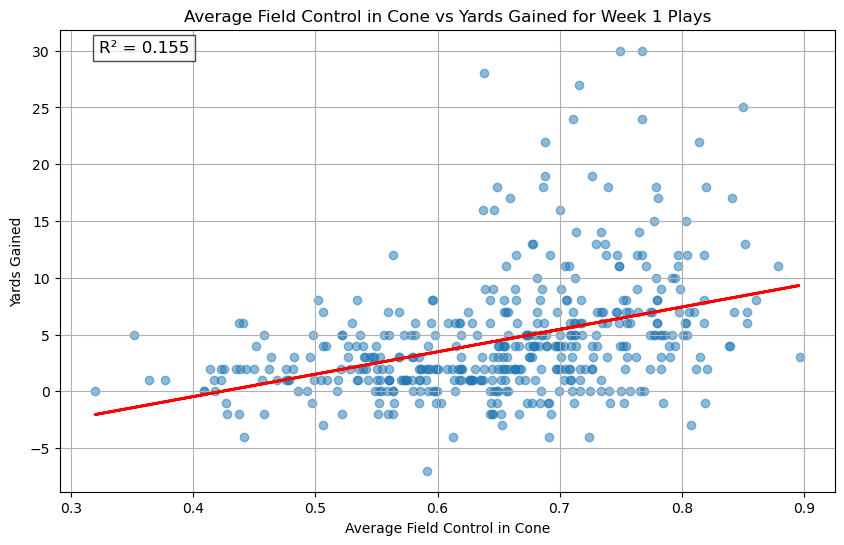

In [30]:
# plot the relationship
import matplotlib.pyplot as plt

plays_wk1 = plays.merge(
    pd.DataFrame.from_dict(play_results, orient='index', columns=['avg_field_control_in_cone']),
    left_on='game_play_id',
    right_index=True,
    how='left'
).dropna(
    subset=['avg_field_control_in_cone']
).assign(
    yards_gained_first_4=plays['yards_gained'].fillna(0).clip(upper=30)
)

x = 'avg_field_control_in_cone'

plt.figure(figsize=(10, 6))
plt.scatter(plays_wk1[x], plays_wk1['yards_gained_first_4'], alpha=0.5)
# best fit line
m, b = np.polyfit(plays_wk1[x], plays_wk1['yards_gained_first_4'], 1)
plt.plot(plays_wk1[x], m * plays_wk1[x] + b, color='red', linewidth=2, label='Best Fit Line')
# plot r squared
r2 = np.corrcoef(plays_wk1[x], plays_wk1['yards_gained_first_4'])[0, 1] ** 2
plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.title('Average Field Control in Cone vs Yards Gained for Week 1 Plays')
plt.xlabel('Average Field Control in Cone')
plt.ylabel('Yards Gained')
plt.grid()
plt.show()

In [31]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(plays_wk1['avg_field_control_in_cone'], plays_wk1['yards_gained_first_4'])
print(f"p-value: {p_value:.20f}")

p-value: 0.00000000000000000988


In [32]:
# Process all plays
play_results_all = {}
game_play_ids = plays['game_play_id'].unique().tolist()
for game_play_id in tqdm(game_play_ids, desc='Calculating Field Control in Cones for week 1', total=len(game_play_ids)):
    avg_fc = calculate_play_rb_field_control(game_play_id, cone_granularity=0.5)
    play_results_all[game_play_id] = avg_fc

Calculating Field Control in Cones for week 1: 100%|██████████| 3623/3623 [32:30<00:00,  1.86it/s]


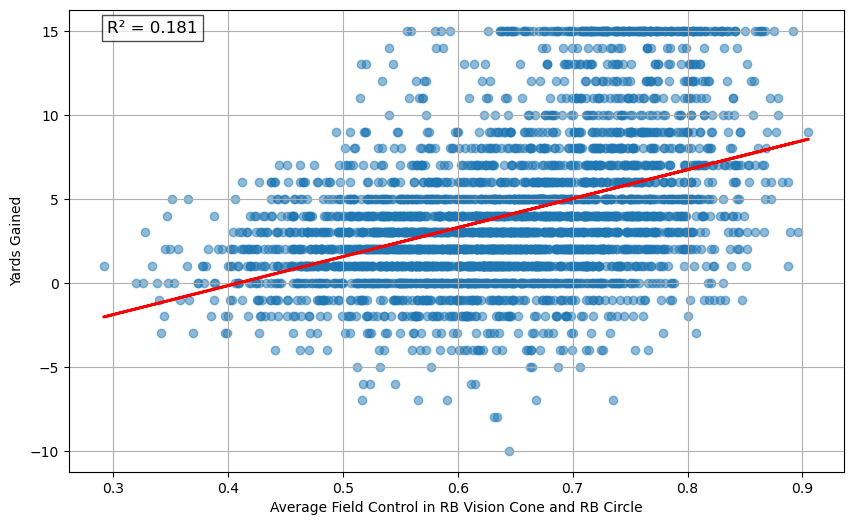

In [39]:
# plot the relationship
import matplotlib.pyplot as plt

plays_wk1 = plays.merge(
    pd.DataFrame.from_dict(play_results_all, orient='index', columns=['avg_field_control_in_cone']),
    left_on='game_play_id',
    right_index=True,
    how='left'
).dropna(
    subset=['avg_field_control_in_cone']
).assign(
    yards_gained_first_4=plays['yards_gained'].fillna(0).clip(upper=15)
)

x = 'avg_field_control_in_cone'

plt.figure(figsize=(10, 6))
plt.scatter(plays_wk1[x], plays_wk1['yards_gained_first_4'], alpha=0.5)
# best fit line
m, b = np.polyfit(plays_wk1[x], plays_wk1['yards_gained_first_4'], 1)
plt.plot(plays_wk1[x], m * plays_wk1[x] + b, color='red', linewidth=2, label='Best Fit Line')
# plot r squared
r2 = np.corrcoef(plays_wk1[x], plays_wk1['yards_gained_first_4'])[0, 1] ** 2
plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.xlabel('Average Field Control in RB Vision Cone and RB Circle')
plt.ylabel('Yards Gained')
plt.grid()
plt.show()